In [1]:
import sys
import os
import math
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_theme(style='whitegrid', # darkgrid, whitegrid, dark, white, ticks)
            context='notebook', # paper, notebook, talk, poster
            palette='tab10', # deep, muted, bright, pastel, dark, colorblind, hls, tab10
                      # for more info, https://seaborn.pydata.org/tutorial/color_palettes.html
             )
print(sys.version)
print("Seaborn version {}".format(sns.__version__))

3.9.20 (main, Sep  6 2024, 19:03:56) 
[Clang 15.0.0 (clang-1500.1.0.2.5)]
Seaborn version 0.12.2


In [2]:
import time
from matplotlib import cm

In [3]:
def Soln(x,y):
    w=0.5
    return np.exp(- ((x-0.3)**2 + (y-0.1) **2)/ w**2 )

def NablaSoln(x,y):
    w=0.5
    return -4./w**2 * ( 1. - ( (x-0.3)**2+(y-0.1)**2)/w**2) * Soln(x,y)

In [21]:
def Solve_2D_FD_LaplaceEq(N, verbose=False):

    """Demonstrate a full front-to-back solution of a 2-D Laplace equation
    with finite differences.  It solves
    
       -\nabla^2 u(x,y) = -NablaSoln(x,y),     (x,y) in [-1,1]^2 
       
       subject to the boundary conditions

          u(x,y) = Soln(x,y)     (x,y) in \partial [-1,1]^2

    N -- number of grid-points per dimension
    verbose -- if True, make a few diagnostic plots

    RETURNS
      ErrL2        ErrL2 - rms error of solution
    """

    # grid-spacing 
    dx = 2./(N-1)

    # allocate and fill a matrix A and a vector b, such that the solution u is given by 
    #     A u = b 
    # vectors go over all grid-points (i.e. have length N*N)
    # the matrix A has the size  (N*N, N*N) for a total of N^4 elements.

    b=np.zeros(N*N)
    A = np.ndarray( (N*N,N*N))
    A.fill(0.)

    # helper-function to index vectors of grid-points.  This assigns each grid-point index (ix,iy) 
    # an integer index that we use to index A and b.  
    def idx(ix, iy):
        return ix + N*iy


    #  fill A and b with the relevant data 
    # (1) boundary points 
    #     set A to be identity for those entries, and set the rhs to be the function-value.
    #     This will enforce Dirichlet BCs on u
    #
    for i in range(N):
        A[idx(i,0),   idx(i,0)]   = 1.;   b[idx(i,0)]   = Soln(i*dx-1,  -1.)
        A[idx(i,N-1), idx(i,N-1)] = 1.;   b[idx(i,N-1)] = Soln(i*dx-1,   1.)
        A[idx(0,i),   idx(0,i)]   = 1.;   b[idx(0,i)]   = Soln(-1., i*dx-1)
        A[idx(N-1,i), idx(N-1,i)] = 1.;   b[idx(N-1,i)] = Soln( 1,  i*dx-1)

    # (2) interior points
    #         \nabla^2u (ix, iy) = (u_{ix+1,iy + u_{ix-1,iy} + u_{ix, iy+1} + u_{ix, iy-1} - 4 u_{ix,iy} ) / dx^2)  
    #         therefore, the A_{ij} entries are... 
    #             A_{ (ix,iy), (ix,iy)]         =  4/dx^2  
    #             A_{ (ix,iy), (ix+-1, iy+-1) } = -1/dx^2

    for ix in range(1,N-1):
        for iy in range(1,N-1):
            A[idx(ix,iy),   idx(ix, iy)]     =  4./dx**2 ; 
            A[idx(ix,iy),   idx(ix+1, iy)]   = -1./dx**2;   
            A[idx(ix,iy),   idx(ix-1, iy)]   = -1./dx**2;   
            A[idx(ix,iy),   idx(ix, iy+1)]   = -1./dx**2;   
            A[idx(ix,iy),   idx(ix, iy-1)]   = -1./dx**2;   

            # fill b with the source-term 'NablaSoln'
            b[idx(ix,iy)] = -NablaSoln( ix*dx -1., iy*dx - 1.)

    #  here comes the work -- direct matrix inversion
    Ainv=np.linalg.inv(A)

    # now compute u = A^{-1} b.  
    u=np.dot(Ainv,b)

    # compute analytic solution
    x = np.linspace(-1.0,1.0,num=N)
    y = np.linspace(-1.0,1.0,num=N)
    X,Y = np.meshgrid(x, y) # grid of point
    Z = Soln(X, Y) # evaluation of the function on the grid

    err = u.reshape((N,N)) - Z
    errL2 = np.sqrt( np.sum(err*err,axis=None) / (N*N))

    if verbose:
        fig = plt.figure(figsize=(10,5))
        fig.suptitle(f"Poisson equation with FD, N={N}")
        ax0 = fig.add_subplot(1,3, 1)
        ax0.imshow(A)
        ax0.set_title('Structure of A')

        # Plot the surface.
        ax1 = fig.add_subplot(1, 3, 2, projection='3d')
        surf = ax1.plot_surface(X, Y, u.reshape((N,N)),  cmap=cm.coolwarm,
                                linewidth=0.25)

        ax2 = fig.add_subplot(1, 3, 3, projection='3d')
        surf = ax2.plot_surface(X, Y, u.reshape((N,N))-Z,  cmap=cm.coolwarm,
                                linewidth=0.25)
        ax1.set_title(f"N={N}, solution")
        ax2.set_title(f"error  errL2={errL2:0.6f}");

    return errL2

In [22]:
Solve_2D_FD_LaplaceEq(N=7,verbose=True);

In [23]:
Solve_2D_FD_LaplaceEq(N=17,verbose=True);

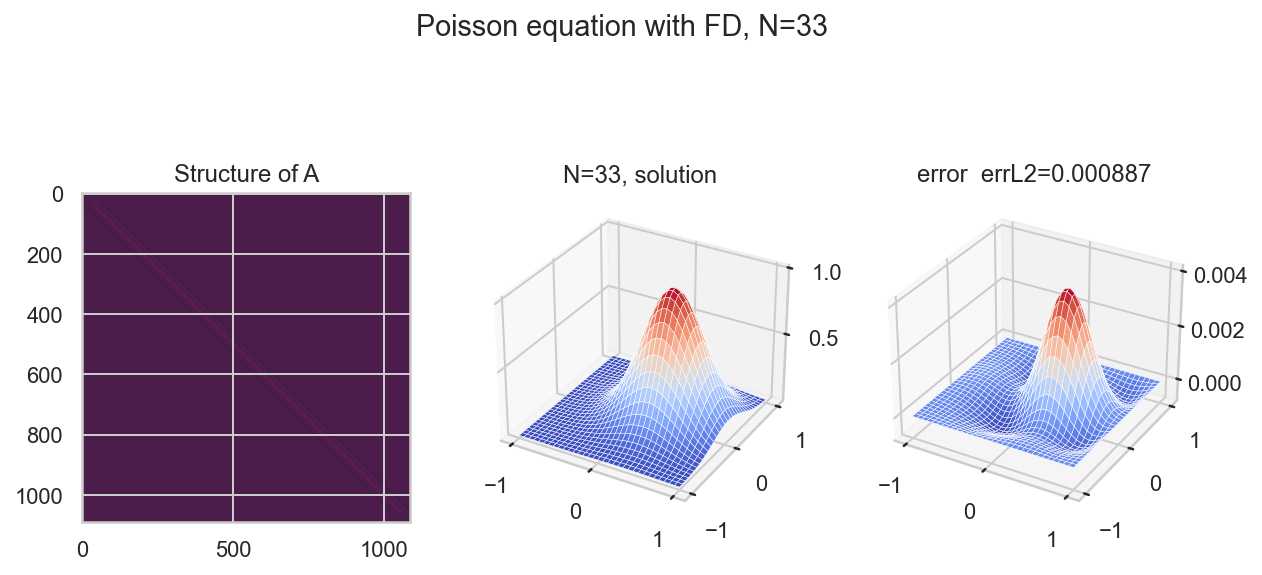

In [24]:
Solve_2D_FD_LaplaceEq(N=33,verbose=True);

In [25]:
N_arr=[5,9,17,25,33,49,65,81,97,113]
err_arr=[]
t_arr = []
for N in N_arr:
    print(f"Solving for N={N:3}... ", end="", flush=True)
    start=time.time()
    err= Solve_2D_FD_LaplaceEq(N=N)
    end=time.time()
    t=end-start
    print(f"ErrL2={err:0.7f}, elapsed time={t:2.2f}", flush=True)
    err_arr.append(err)
    t_arr.append(t)

N_arr=np.array(N_arr)
err_arr=np.array(err_arr)
t_arr=np.array(t_arr)


Solving for N=  5... ErrL2=0.0543168, elapsed time=0.00
Solving for N=  9... ErrL2=0.0137031, elapsed time=0.01
Solving for N= 17... ErrL2=0.0034793, elapsed time=0.04
Solving for N= 25... ErrL2=0.0015656, elapsed time=0.02
Solving for N= 33... ErrL2=0.0008873, elapsed time=0.06
Solving for N= 49... ErrL2=0.0003976, elapsed time=0.42
Solving for N= 65... ErrL2=0.0002247, elapsed time=1.57
Solving for N= 81... ErrL2=0.0001442, elapsed time=5.71
Solving for N= 97... ErrL2=0.0001003, elapsed time=18.13
Solving for N=113... ErrL2=0.0000738, elapsed time=40.05


In [28]:
fig,ax=plt.subplots(1,3, figsize=(16,6))
ax[0].loglog(N_arr, err_arr, '-o', label='ErrL2')
ax[0].plot(N_arr, err_arr[-1] * (N_arr / N_arr[-1])**(-2), label =r"$\propto N^{-2}$" )
ax[0].set_xlabel('N')
ax[0].set_ylabel('ErrL2');
ax[0].legend(fontsize='large');

ax[1].loglog(N_arr, t_arr, '-o', label='execution time')
ax[1].plot(N_arr, t_arr[-1] * (N_arr / N_arr[-1])**6, label =r"$\propto N^6$" )
ax[1].set_xlabel('N')
ax[1].set_ylabel('execution time')
ax[1].legend(fontsize='large');


ax[2].loglog(t_arr, err_arr, '-o', label='ErrL2')
ax[2].plot(t_arr, err_arr[-1] * (t_arr / t_arr[-1])**(-1/3), label =r"$\propto t^{-1/3}$" )
ax[2].set_xlabel('execution time')
ax[2].set_ylabel('ErrL2')
ax[2].legend(fontsize='large');
